<a href="https://colab.research.google.com/github/CarlosESalinas/weather_classification/blob/main/Weahter_multi_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1 align="center"> Clasificación de imágenes del Clima</h1>

# Introducción

<p> Este proyecto es parte de la entrega final para el seminario <i>Temas Selectos de Física Computacional: Introducción a Redes Neuronales</i>, del periodo 2023-2. El tema seleccionado fue clasificación de imágenes; la clasificación de imágenes se inscribe dentro del campo de la Visión por Computadora (Computer Vision). De manera general, la Visión por Computadora se enfoca en desarrollar algoritmos y técnicas que permitan a las máquinas comprender, analizar e interpretar imágenes y videos de manera similar a como lo hacen los seres humanos.</p>

<p> La clasificación de imágenes es una de las tareas más comunes y básicas en el campo de Visión por Computadora y consiste en asignar una etiqueta o categoría a una imagen determinada, lo cual implica reconocer patrones y características visuales específicas en la imagen para poder realizar la clasificación. </p>

<p> El problema de este proyecto consiste en clasificar imágenes del clima entre nublado (cloudy), lluvioso (rain), amancer (sunrise) y soleado (shine), mediante una Red Neuronal Convolucional (CNN, por sus siglas en inglés, Convolution Neural Networks). La base de datos con la que se trabajó se puede consultar en el siguiente <A href="https://data.mendeley.com/datasets/4drtyfjtfy/1">link</A>. </p>

<p> El conjunto de datos proporciona una plataforma para el análisis meteorológico en exteriores mediante la extracción de diversas características para reconocer las diferentes condiciones meteorológicas.</p>

<h2> Objetivos</h2>

Se tiene como objetivos:
<ul>
  <li> Exploración de los datos.</li>
  <li> Procesamiento de los datos. </li>
  <li> Creación de tres modelo CNN para la clasificación del conjunto de datos. </li>
  <li> Carga y ajuste de un modelo pre-entreando. </li>
  <li> Evaluación de los modelos CNN. </li>
</ul>

<h2> Plan de acción </h2>

Para facilitar la lectura de este proyecto, se propone el siguente orden:
<ol>
<li> Exploración de datos. </li>
<li> Procesamiento de datos. </li>
<li> Construcción y ajuste de los modelos CNN. </li>
<li> Carga y ajuste de modelo pre-entrenado. </li>
<li> Presentación de resultados. </li>
<li> Conclusiones. </li>
</ol>


# 1. Exploración de datos

## 1.1 Instalación de librerías


In [ ]:
# Librerías

import os

## Librería para manipulación de datos

import pandas as pd

## Librería para cálculos con arreglos matriciales

import numpy as np

## Librería para el cálculo del tiempo

import time

## Librerías deep learning

import tensorflow as tf
from keras.models import Sequential
from tensorflow.keras.models import Model
from keras.layers import Activation, Dropout, Flatten, Dense
from keras.layers import  BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.layers import Dense, Dropout, Flatten, Input
from tensorflow.keras.layers import MaxPool2D, Conv2D, MaxPooling2D

## Librerías para el procesamiento de los datos
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.utils import to_categorical, plot_model


## Librería para visualización de datos
import matplotlib.pyplot as plt

## 1.2 Carga de los datos

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
## path del conjunto de datos
Weather_data = '/content/drive/MyDrive/Weather_data/Multi-class Weather Dataset/'
#/content/drive/MyDrive/Weather_data/Multi-class Weather Dataset/

In [ ]:
## Extracción de los archivos
Cloudy = '/content/drive/MyDrive/Weather_data/Multi-class Weather Dataset/Cloudy'
Rain = '/content/drive/MyDrive/Weather_data/Multi-class Weather Dataset/Rain'
Shine = '/content/drive/MyDrive/Weather_data/Multi-class Weather Dataset/Shine'
Sunrise = '/content/drive/MyDrive/Weather_data/Multi-class Weather Dataset/Sunrise'

## 1.3 Análisis Exploratorio de los datos

In [ ]:
folders = os.listdir(Weather_data)
print(f"Los folders son: {folders}")

Los folders son: ['Sunrise', 'Rain', 'Cloudy', 'Shine']


In [ ]:
## Contabilzar el número de muestras por cada clase
num_weather = [len(os.listdir(os.path.join(Weather_data + x))) for x in folders]
weather_df = pd.DataFrame({'labels':folders, 'num_weather':num_weather}).sort_values('num_weather', ascending=False)
weather_df

labels  num_weather
0  Sunrise          357
2   Cloudy          300
3    Shine          253
1     Rain          215

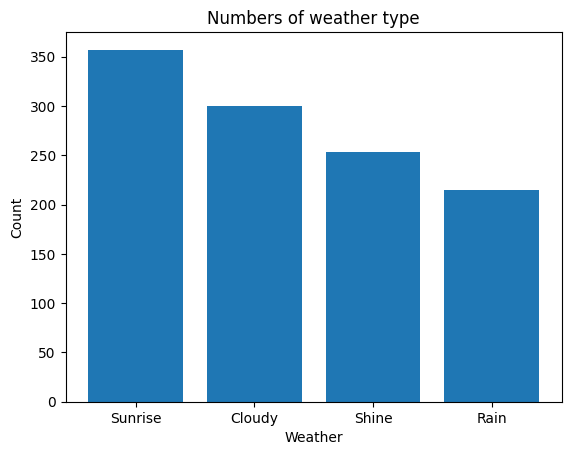

In [ ]:
# Crear el gráfico de barras
plt.bar(weather_df['labels'], weather_df['num_weather'])

# Añadir títulos y etiquetas de los ejes
plt.title('Numbers of weather type')
plt.xlabel('Weather')
plt.ylabel('Count')

# Mostrar el gráfico
plt.show()

In [ ]:
## Función para visualizar las imagenes

def view_picture(File):
  plt.figure(figsize= (8,8))
  for i in range(9):
    plt.subplot(3, 3, i +1)
    image = plt.imread(os.path.join(File, os.listdir(File)[i]))
    plt.imshow(image)


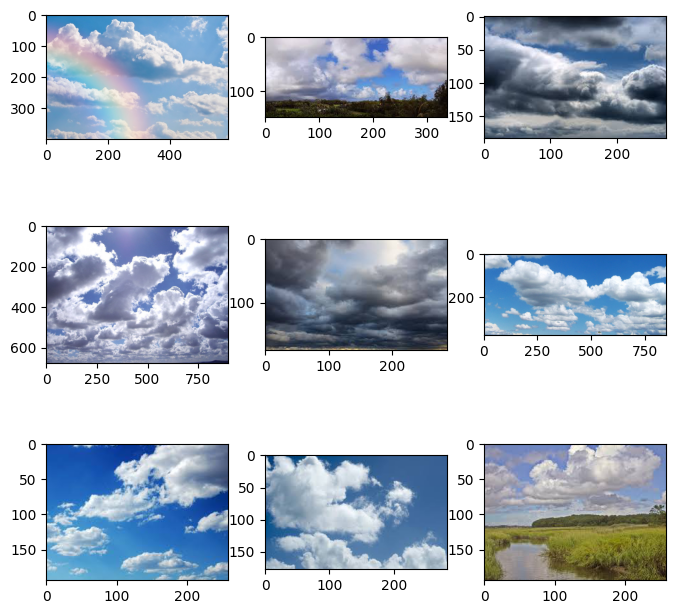

In [ ]:
view_picture(Cloudy)

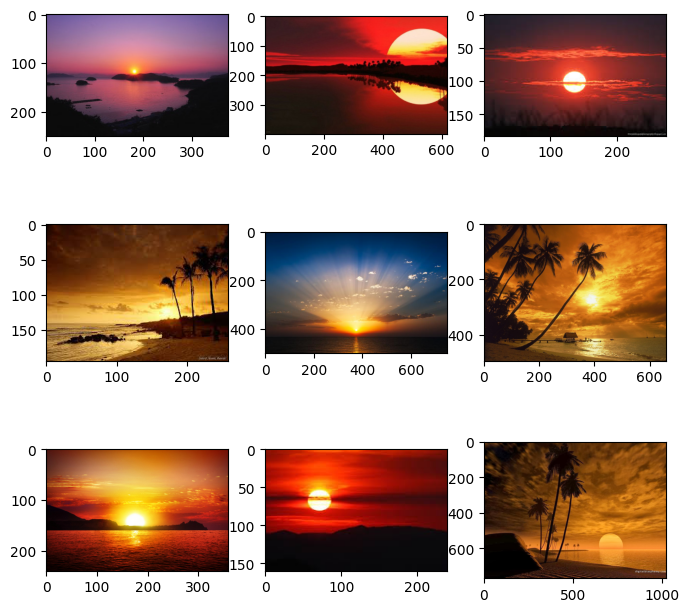

In [ ]:
view_picture(Sunrise)

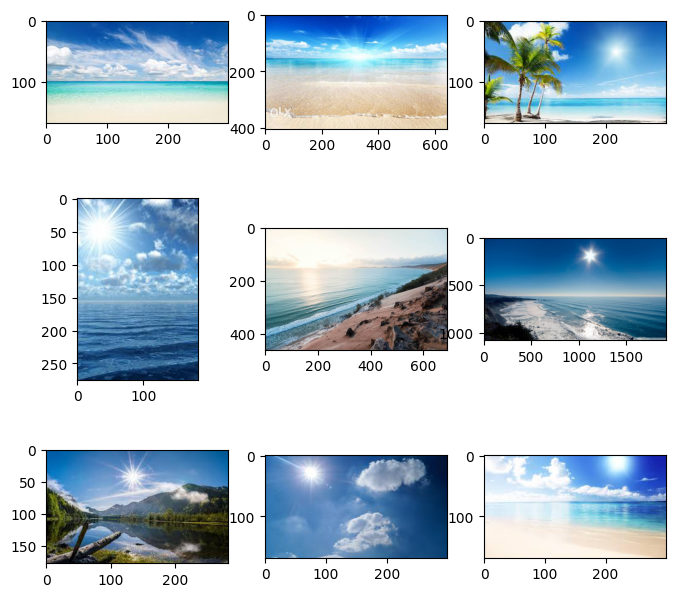

In [ ]:
view_picture(Shine)

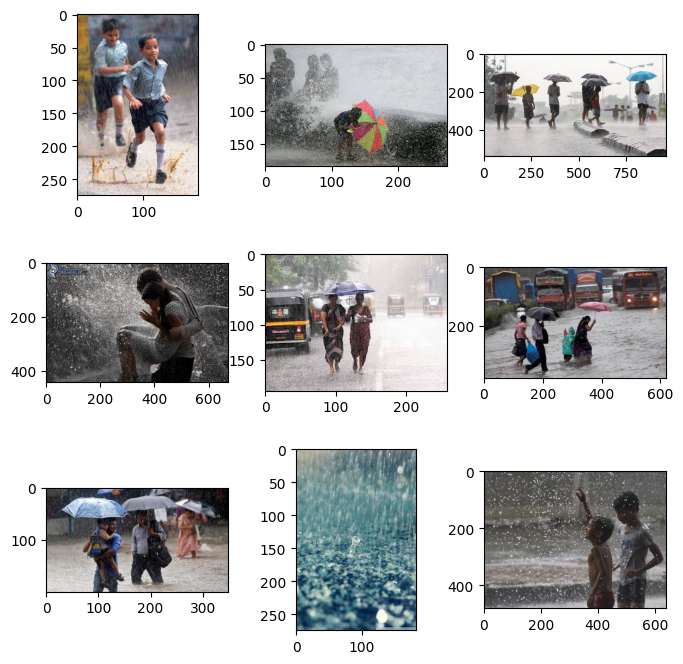

In [ ]:
view_picture(Rain)

<b> Inferencia</b>: la base de datos contiene 4 clases distintas correspondientes a cada uno de los climas. Sin embargo, el conjuto de datos no contiene un número significativo deatos y, además, cada imagen difieren en tamaño, por lo que es necesario realizar un procesamiento de datos con la finalidad en primer lugar, estandarizar las imágenes a un mismo tamaño y, segundo, aumentar la muestra de los datos.

# 2. Procesamiento de los datos

<p> <b> ImageDataGenerator</b> es una herramienta muy útil en TensorFlow para la generación y aumento de datos de imágenes para entrenar modelos de aprendizaje profundo. Proporciona una forma conveniente de preprocesar y aumentar imágenes en tiempo real mientras se alimentan al modelo durante el entrenamiento.</p>

<p>El propósito principal de ImageDataGenerator es crear un flujo continuo de datos de imágenes en lotes, lo que permite un entrenamiento más eficiente y escalable de modelos de aprendizaje automático. Toma un conjunto de imágenes como entrada y realiza varias transformaciones y aumentos de datos en tiempo real.</p>

## 2.1 Aplicación de ImageDataGenerator


In [ ]:
train_data = ImageDataGenerator(
                                # Rescalado de los valores en [0,1]
                                rescale =1. /255,
                                # Transformaciones a las imágenes
                                shear_range=0.2,
                                # Acercamientos/alejamientos de las imágenes
                                zoom_range=0.2,
                                # Rotoción de las imágenes
                                horizontal_flip=True,
                                # División de datos train/validation
                                validation_split=0.2)

train_generator = train_data.flow_from_directory(
                                                  Weather_data,
                                                  # Tamaño de las imágenes
                                                  target_size=(250 , 250),
                                                  # Tamaño de los lotes
                                                  batch_size= 32,
                                                  # Modo de clasificación
                                                  class_mode='categorical',
                                                  # Selección de datos de training
                                                  subset='training')

validation_generator = train_data.flow_from_directory(
                                                      Weather_data,
                                                      target_size=(250, 250),
                                                      batch_size= 32,
                                                      class_mode='categorical',
                                                      # Selección de datos de val
                                                      subset='validation')

Found 901 images belonging to 4 classes.
Found 224 images belonging to 4 classes.


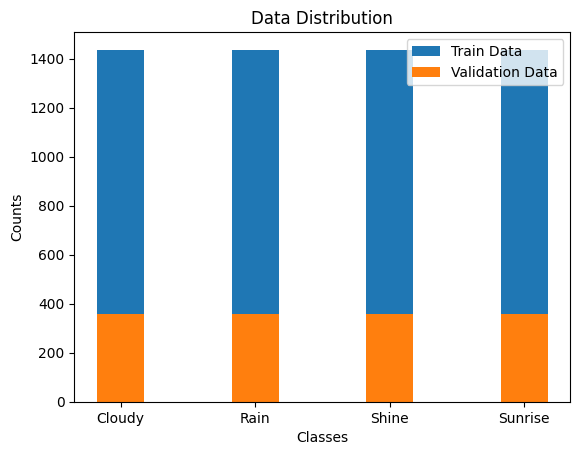

In [ ]:
# Obtener las clases del generador de datos
class_names = train_generator.class_indices

# Obtener el recuento de imágenes por clase en el conjunto de entrenamiento
train_counts = train_generator.classes.sum(axis=0)

# Obtener el recuento de imágenes por clase en el conjunto de validación
validation_counts = validation_generator.classes.sum(axis=0)

# Crear una lista con las etiquetas de las clases
labels = list(class_names.keys())

# Configurar el gráfico de barras
x = range(len(labels))
width = 0.35

# Crear la figura y los ejes
fig, ax = plt.subplots()

# Generar las barras
train_bars = ax.bar(x, train_counts, width, label='Train Data')
validation_bars = ax.bar(x, validation_counts, width, label='Validation Data')

# Agregar etiquetas a las barras
ax.set_ylabel('Counts')
ax.set_xlabel('Classes')
ax.set_title('Data Distribution')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

# Mostrar el gráfico de barras
plt.show()


/usr/local/lib/python3.10/dist-packages/matplotlib/text.py:1279: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


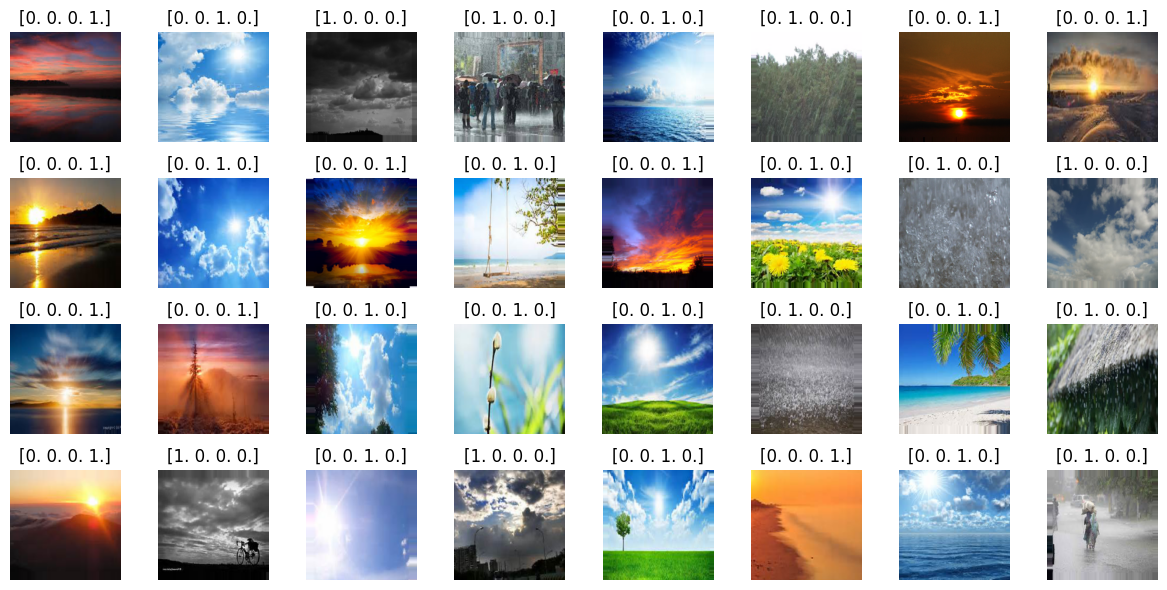

In [ ]:
## Visualización de los cambios

# Obtener un lote de imágenes y etiquetas del generador
images, label = train_generator.next()

# Visualizar las imágenes del lote
fig, axes = plt.subplots(4, 8, figsize=(12, 6))
axes = axes.ravel()

for i in range(32):
    axes[i].imshow(images[i])
    axes[i].axis('off')
    axes[i].set_title(label[i])
plt.tight_layout()
plt.show()

<b> Inferencia</b>: Se ha aplicado correctamente el procesamiento de los datos y se ha aumentado el número de muestras.

# 3. Construcción y ajuste de los modelos CNN


<p> Se crean dos modelos de Redes Neuronales Convolucionales o CNN. Las redes convolucionales son un tipo de arquitectura de redes neuronales profundas especialmente diseñadas para el procesamiento de datos de tipo grid, como imágenes y señales de audio.</p>

<p>A diferencia de las redes neuronales tradicionales (también conocidas como redes neuronales totalmente conectadas o perceptrones multicapa), las CNN están diseñadas para aprovechar la estructura espacial presente en los datos de tipo grid. Esto significa que reconocen que las relaciones entre los elementos de un grid (por ejemplo, los píxeles de una imagen) son importantes y que las características relevantes se pueden encontrar en regiones locales en lugar de considerar cada entrada por separado.</p>

<p> A continuación se crean dos modelos, el primero de ellos es el más simple respecto a su topología, pero sirvío como modelo para la topología del segundo. </p>

## 3.1 Primer modelo Convolucional

In [ ]:
model1= Sequential()
# # Definir la entrada
model1.add(Conv2D(64, (3,3), strides=(1,1), padding='same', activation='relu',
                  input_shape= (250, 250, 3)))

# Capa convolucional 1
model1.add(Conv2D(32, (3, 3), activation='relu'))
model1.add(MaxPooling2D((2, 2)))

# Capa convolucional 2
model1.add(Conv2D(64, (3, 3), activation='relu'))
model1.add(MaxPooling2D((2, 2)))

# Capa de aplanamiento
model1.add(Flatten())

# Capa completamente conectada
model1.add(Dense(128, activation='relu'))

# Capa de salida
model1.add(Dense(4, activation='softmax'))

model1.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 250, 250, 64)      1792      
                                                                 
 conv2d_1 (Conv2D)           (None, 248, 248, 32)      18464     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 124, 124, 32)     0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 122, 122, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 61, 61, 64)       0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 238144)            0

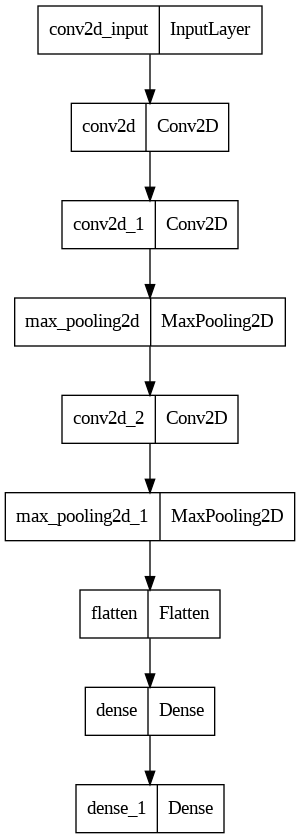

In [ ]:
plot_model(model1, show_dtype=False, show_layer_names=True)

In [ ]:
# Compilar el modelo
model1.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
# Calcular el tiempo transcurrido
epochs = 20

# Iniciar el temporizador
start_time = time.time()

## Entrenamiento del modelo
history = model1.fit(train_generator, epochs=epochs, validation_data=validation_generator)

end_time = time.time()

Epoch 1/20
29/29 [==============================] - 233s 8s/step - loss: 2.5499 - accuracy: 0.5383 - val_loss: 0.7651 - val_accuracy: 0.7812
Epoch 2/20
29/29 [==============================] - 23s 800ms/step - loss: 0.5399 - accuracy: 0.8013 - val_loss: 0.5100 - val_accuracy: 0.7946
Epoch 3/20
29/29 [==============================] - 24s 832ms/step - loss: 0.3836 - accuracy: 0.8590 - val_loss: 0.9296 - val_accuracy: 0.7589
Epoch 4/20
29/29 [==============================] - 24s 807ms/step - loss: 0.4191 - accuracy: 0.8413 - val_loss: 0.7973 - val_accuracy: 0.7634
Epoch 5/20
29/29 [==============================] - 24s 848ms/step - loss: 0.3846 - accuracy: 0.8468 - val_loss: 0.9035 - val_accuracy: 0.7366
Epoch 6/20
29/29 [==============================] - 24s 842ms/step - loss: 0.3525 - accuracy: 0.8690 - val_loss: 0.5239 - val_accuracy: 0.8170
Epoch 7/20
29/29 [==============================] - 25s 859ms/step - loss: 0.3163 - accuracy: 0.8846 - val_loss: 0.5360 - val_accuracy: 0.7946
E

In [ ]:
## Calcular el tiempo de entrenamiento
training_time = end_time - start_time

# Convertir los tiempos a minutos
training_time_min = training_time / 60

# Imprimir los resultados
print(f"Tiempo de entrenamiento total del modelo 1: {training_time_min:.2f} minutos")

Tiempo de entrenamiento total del modelo 1: 13.20 minutos


### 3.1.1 Resultados del Modelo 1

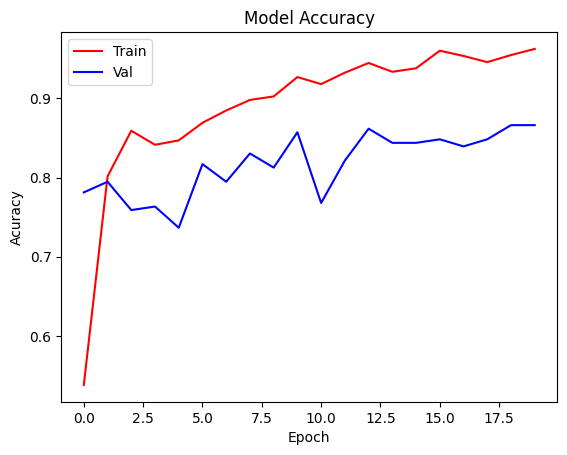

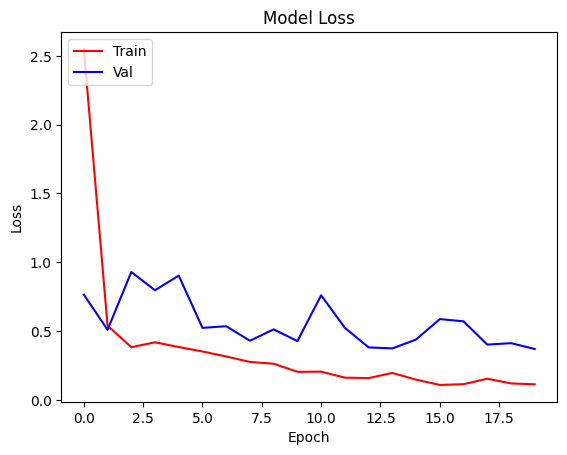

In [ ]:
# Graficas de accuracy
plt.figure()
plt.plot(history.history['accuracy'], 'r')
plt.plot(history.history['val_accuracy'], 'b')
plt.title('Model Accuracy')
plt.ylabel('Acuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()
# Graficas de loss
plt.plot(history.history['loss'], 'r')
plt.plot(history.history['val_loss'], 'b')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

In [ ]:
# Evaluar el modelo en el conjunto de prueba
Loss, Accuracy = model1.evaluate(validation_generator)

print(f"Loss: {Loss*100:.2f}%")
print(f"Accuracy: {Accuracy*100:.2f}%")

7/7 [==============================] - 6s 871ms/step - loss: 0.3558 - accuracy: 0.8750
Loss: 35.58%
Accuracy: 87.50%


### 3.1.2 Predicción del Modelo 1

In [ ]:
## Función para predecir con datos nuevos
def prediction(path_image):

  img = image.load_img(path_image , target_size = (250 , 250))
  img = image.img_to_array(img, dtype=np.uint8)
  img = np.array(img)/255.0

  # plt.title('Image')
  plt.axis('off')
  plt.imshow(img.squeeze())

  predict = model1.predict(img[np.newaxis , ...])
  predicted_class = labels[np.argmax(predict[0] , axis = -1)]

  print('Prediction Value: ' , np.max(predict[0] , axis = -1))
  print("Classified:",predicted_class)

1/1 [==============================] - 0s 347ms/step
Prediction Value:  0.73261744
Classified: Shine


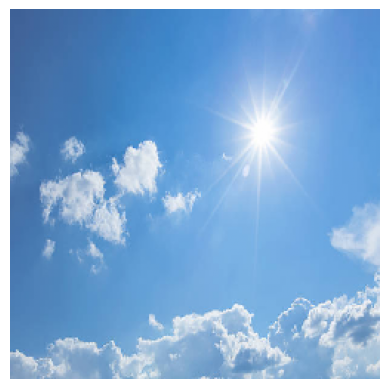

In [ ]:
path_image = '/content/img.jpg'
prediction(path_image)

1/1 [==============================] - 0s 17ms/step
Prediction Value:  0.81428444
Classified: Cloudy


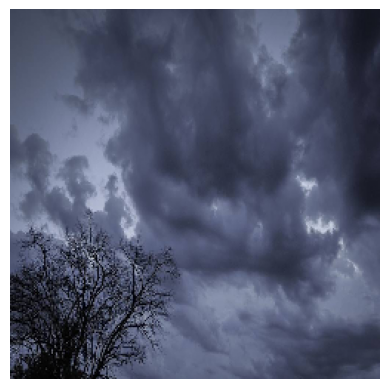

In [ ]:
path_image = '/content/img2.jpg'
prediction(path_image)

1/1 [==============================] - 0s 17ms/step
Prediction Value:  0.9986255
Classified: Rain


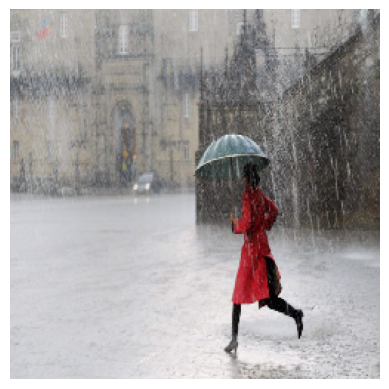

In [ ]:
path_image = '/content/img3.jpg'
prediction(path_image)

1/1 [==============================] - 0s 19ms/step
Prediction Value:  0.99999917
Classified: Sunrise


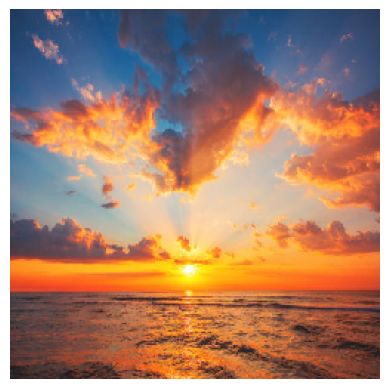

In [ ]:
path_image = '/content/img4.jpg'
prediction(path_image)

<b> Inferencia</b>: los resultados del modelo fueron los siguientes:
<ul>
<li> Función de pérdida >> 35.58%.</li>
<li> Tasa de aciertos >> 87.50%.</li>
<li> El modelo presenta sobreajuste.</li>
<li> Clasificó "bien" con nuevos datos.</li>
</ul>

## 3.2 Segundo modelo Convolucional

In [ ]:
model2 = Sequential()
model2.add(Conv2D(64, (3,3), strides=(1,1), padding='same', activation='relu',
                  input_shape = (250,250,3)))
model2.add(Conv2D(128, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu'))
model2.add(Dropout(0.3))
model2.add(MaxPool2D(2,2))
model2.add(Conv2D(256, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu'))
model2.add(Dropout(0.3))
model2.add(MaxPool2D(2,2))
model2.add(Conv2D(512, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu'))
model2.add(Dropout(0.3))
model2.add(MaxPool2D(2,2))
model2.add(Flatten())
model2.add(Dense(200, activation='relu'))
model2.add(Dropout(0.3))
model2.add(Dense(4, activation='softmax'))

model2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 250, 250, 64)      1792      
                                                                 
 conv2d_4 (Conv2D)           (None, 250, 250, 128)     73856     
                                                                 
 dropout (Dropout)           (None, 250, 250, 128)     0         
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 125, 125, 128)    0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 125, 125, 256)     295168    
                                                                 
 dropout_1 (Dropout)         (None, 125, 125, 256)     0         
                                                      

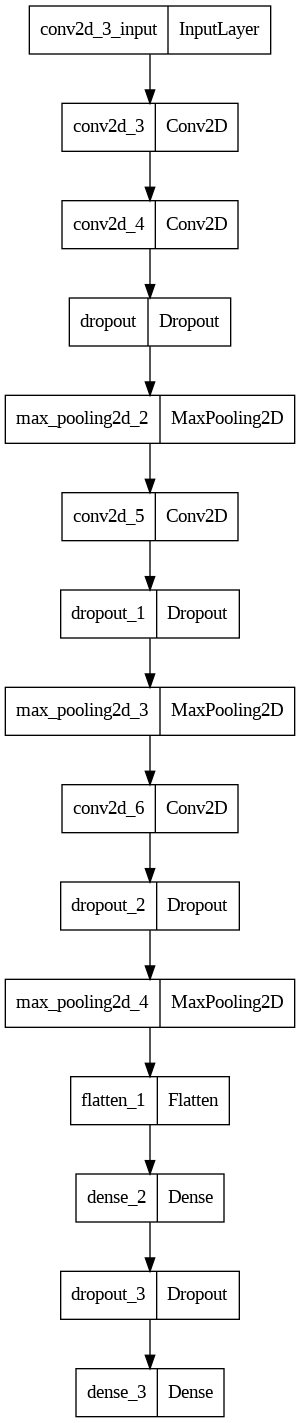

In [ ]:
plot_model(model2, show_dtype=False, show_layer_names=True)

In [ ]:
model2.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=['accuracy'])

In [ ]:
# Configurar el número de épocas
epochs = 30

# Iniciar el temporizador
start_time = time.time()

# Entrenar el modelo
history = model2.fit(train_generator,
                    validation_data = validation_generator,
                    epochs = epochs,
                    steps_per_epoch = 901/32,
                    validation_steps = 224/32)

end_time = time.time()

Epoch 1/30
28/28 [==============================] - 52s 1s/step - loss: 4.1167 - accuracy: 0.5594 - val_loss: 0.8267 - val_accuracy: 0.6875
Epoch 2/30
28/28 [==============================] - 32s 1s/step - loss: 0.5840 - accuracy: 0.7680 - val_loss: 0.7377 - val_accuracy: 0.7545
Epoch 3/30
28/28 [==============================] - 32s 1s/step - loss: 0.4979 - accuracy: 0.8047 - val_loss: 0.7319 - val_accuracy: 0.7902
Epoch 4/30
28/28 [==============================] - 30s 1s/step - loss: 0.4808 - accuracy: 0.8124 - val_loss: 0.6219 - val_accuracy: 0.8125
Epoch 5/30
28/28 [==============================] - 30s 1s/step - loss: 0.4417 - accuracy: 0.8169 - val_loss: 0.8219 - val_accuracy: 0.7054
Epoch 6/30
28/28 [==============================] - 32s 1s/step - loss: 0.4971 - accuracy: 0.8102 - val_loss: 0.8274 - val_accuracy: 0.6830
Epoch 7/30
28/28 [==============================] - 33s 1s/step - loss: 0.4106 - accuracy: 0.8235 - val_loss: 0.7544 - val_accuracy: 0.7902
Epoch 8/30
28/28 [==

In [ ]:
## Calcular el tiempo de entrenamiento
training_time = end_time - start_time

# Convertir los tiempos a minutos
training_time_min = training_time / 60

# Imprimir los resultados
print(f"Tiempo de entrenamiento total del modelo 2: {training_time_min:.2f} minutos")

Tiempo de entrenamiento total del modelo 2: 17.87 minutos


### 3.2.1 Resultados del Modelo 2

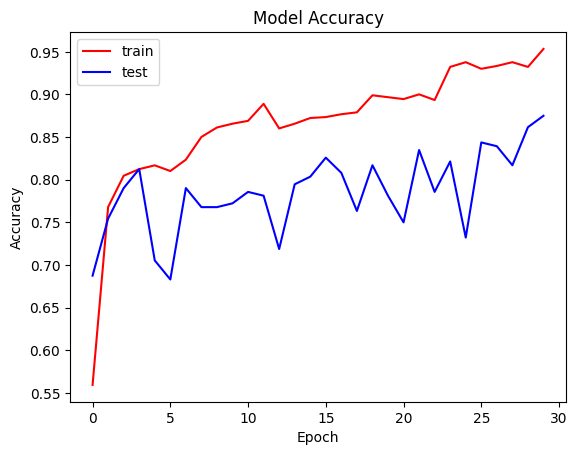

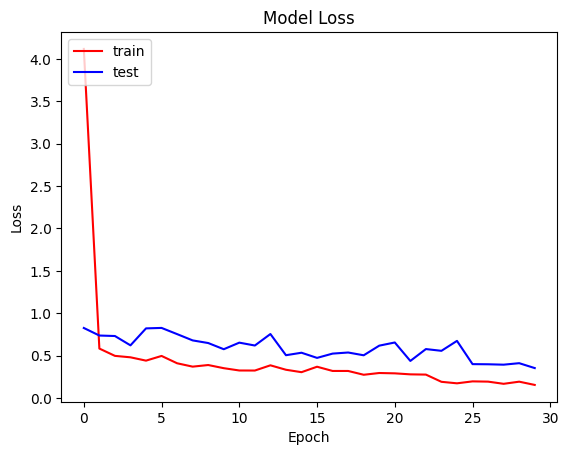

In [ ]:
## modelo 4
# Graficas de accuracy
plt.plot(history.history['accuracy'], 'r')
plt.plot(history.history['val_accuracy'], 'b')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# Graficas de loss
plt.plot(history.history['loss'], 'r')
plt.plot(history.history['val_loss'], 'b')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
Loss, Accuracy = model2.evaluate(train_generator)

print(f"Loss: {Loss*100:.2f}%")
print(f"Accuracy: {Accuracy*100:.2f}%")

29/29 [==============================] - 18s 629ms/step - loss: 0.1657 - accuracy: 0.9612
Loss: 16.57%
Accuracy: 96.12%


### 3.2.2 Predicción del Modelo 2

In [ ]:
def prediction(path_image):

  img = image.load_img(path_image , target_size = (250 , 250))
  img = image.img_to_array(img, dtype=np.uint8)
  img = np.array(img)/255.0

  # plt.title('Image')
  plt.axis('off')
  plt.imshow(img.squeeze())

  predict = model2.predict(img[np.newaxis , ...])
  predicted_class = labels[np.argmax(predict[0] , axis = -1)]

  print('Prediction Value: ' , np.max(predict[0] , axis = -1))
  print("Classified:",predicted_class)

1/1 [==============================] - 0s 413ms/step
Prediction Value:  0.88951015
Classified: Shine


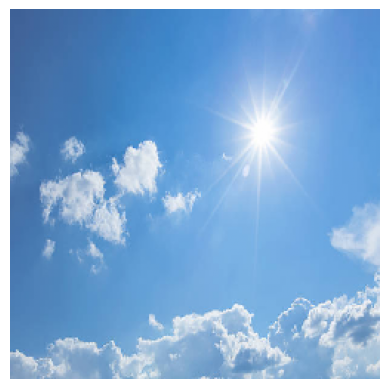

In [ ]:
path_image = '/content/img.jpg'
prediction(path_image)

1/1 [==============================] - 0s 22ms/step
Prediction Value:  0.76897836
Classified: Cloudy


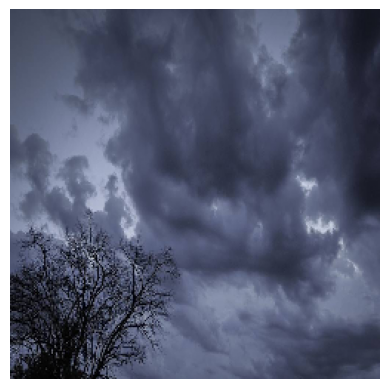

In [ ]:
path_image = '/content/img2.jpg'
prediction(path_image)

1/1 [==============================] - 0s 19ms/step
Prediction Value:  0.9662705
Classified: Rain


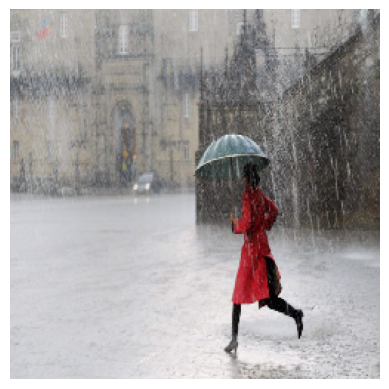

In [ ]:
path_image = '/content/img3.jpg'
prediction(path_image)

1/1 [==============================] - 0s 18ms/step
Prediction Value:  0.999997
Classified: Sunrise


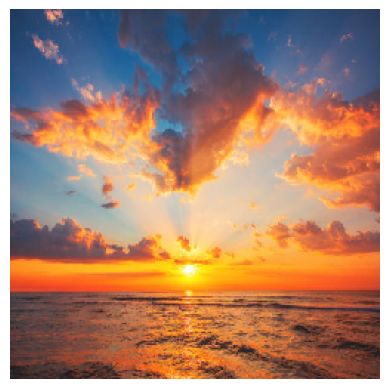

In [ ]:
path_image = '/content/img4.jpg'
prediction(path_image)

<b> Inferencia</b>: los resultados del segundo modelo son:
<ul>
  <li> El modelo presenta sobre ajuste. </li>
  <li> Función de pérdida >> 16.57%.</li>
  <li> Tasa de acierto >> 96.12%.</li>
  <li> Clasificó "bien" con nuevos datos.</li>
</ul>

## 3.3 Tercer modelo Convolucional

In [ ]:
model3 = Sequential()

model3.add(Conv2D(64, (3,3), strides=(1,1), padding='same', activation='relu',
                  input_shape = (250,250,3)))
model3.add(Conv2D(128, (3,3), strides=(1,1), padding='same', activation='relu'))
model3.add(MaxPooling2D((2,2)))
model3.add(Dropout(0.3))
model3.add(Conv2D(128, (3,3), strides=(1,1), padding='same', activation='relu'))
model3.add(Dropout(0.3))
model3.add(Conv2D(256, (3,3), strides=(1,1), padding='same', activation='relu'))
model3.add(Conv2D(256, (3,3), strides=(1,1), padding='same', activation='relu'))
model3.add(MaxPooling2D((2,2)))
model3.add(Dropout(0.3))
model3.add(Flatten())
model3.add(Dense(128, activation='relu')) # > Se añadió esta capa
model3.add(Dense(4, activation = 'softmax'))

model3.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_7 (Conv2D)           (None, 250, 250, 64)      1792      
                                                                 
 conv2d_8 (Conv2D)           (None, 250, 250, 128)     73856     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 125, 125, 128)    0         
 2D)                                                             
                                                                 
 dropout_4 (Dropout)         (None, 125, 125, 128)     0         
                                                                 
 conv2d_9 (Conv2D)           (None, 125, 125, 128)     147584    
                                                                 
 dropout_5 (Dropout)         (None, 125, 125, 128)     0         
                                                      

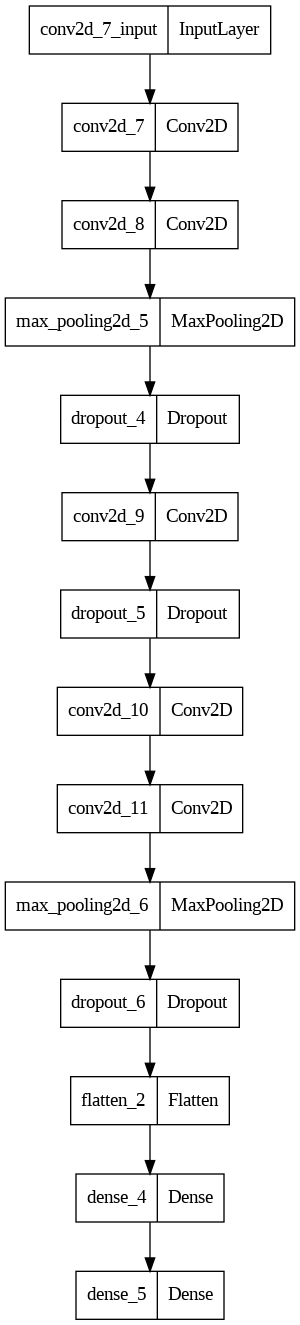

In [ ]:
plot_model(model3, show_dtype=False, show_layer_names=True)

In [ ]:
model3.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=['accuracy'])

In [ ]:
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    # Ruta del archivo
    filepath="D_epoca.{epoch:02d}-{val_loss:.2f}.h5",
    # Se guarda todo el modelo
    save_weights_only=False,
    # Se guarda el modelo cuando el conjuto de validaación
    # alcance su valor máximo
    monitor='val_categorical_accuracy',
    # Se guarda el modelo cuando la métrica sea máxima
    mode='max',
    # Se actulizan los peso solo si la métrica mejora
    save_best_only=True)

In [ ]:
# Configurar el número de épocas
epochs = 30

# Iniciar el temporizador
start_time = time.time()
## Entrenar el modelo
history = model3.fit(train_generator,
                    validation_data = validation_generator,
                    epochs = epochs,
                    steps_per_epoch = 901/32,
                    validation_steps = 224/32)

end_time = time.time()

Epoch 1/30
28/28 [==============================] - 54s 1s/step - loss: 4.1604 - accuracy: 0.4961 - val_loss: 0.7713 - val_accuracy: 0.6071
Epoch 2/30
28/28 [==============================] - 35s 1s/step - loss: 0.6731 - accuracy: 0.7081 - val_loss: 0.5785 - val_accuracy: 0.8036
Epoch 3/30
28/28 [==============================] - 34s 1s/step - loss: 0.5082 - accuracy: 0.7825 - val_loss: 0.6445 - val_accuracy: 0.7143
Epoch 4/30
28/28 [==============================] - 34s 1s/step - loss: 0.4594 - accuracy: 0.8080 - val_loss: 0.7311 - val_accuracy: 0.6696
Epoch 5/30
28/28 [==============================] - 33s 1s/step - loss: 0.4294 - accuracy: 0.8047 - val_loss: 0.6553 - val_accuracy: 0.7902
Epoch 6/30
28/28 [==============================] - 34s 1s/step - loss: 0.3927 - accuracy: 0.8335 - val_loss: 0.5340 - val_accuracy: 0.8080
Epoch 7/30
28/28 [==============================] - 34s 1s/step - loss: 0.4047 - accuracy: 0.8402 - val_loss: 0.4952 - val_accuracy: 0.7857
Epoch 8/30
28/28 [==

In [ ]:
## Calcular el tiempo de entrenamiento
training_time = end_time - start_time

# Convertir los tiempos a minutos
training_time_min = training_time / 60

# Imprimir los resultados
print(f"Tiempo de entrenamiento total del modelo 3: {training_time_min:.2f} minutos")

Tiempo de entrenamiento total del modelo 3: 18.27 minutos


### 3.3.1 Resultados del Modelo 3

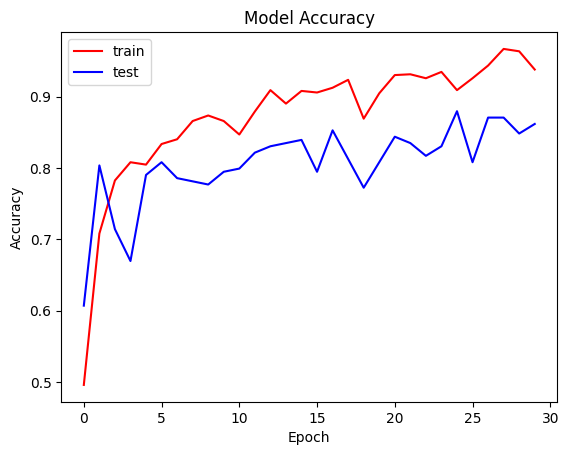

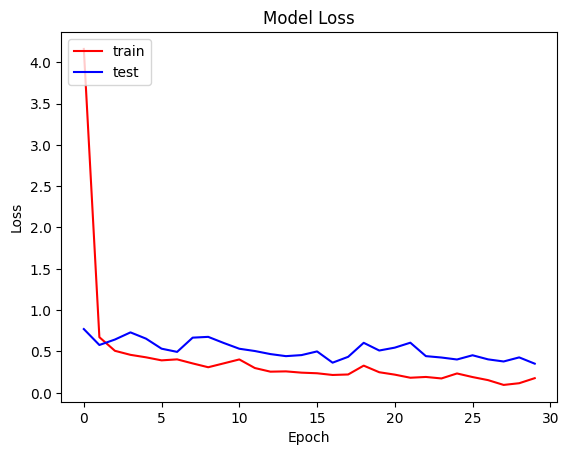

In [ ]:
# Graficas de accuracy
plt.plot(history.history['accuracy'], 'r')
plt.plot(history.history['val_accuracy'], 'b')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# Graficas de loss
plt.plot(history.history['loss'], 'r')
plt.plot(history.history['val_loss'], 'b')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
# Evaluar el modelo en el conjunto de prueba
Loss, Accuracy = model3.evaluate(train_generator)

print(f"Loss: {Loss*100:.2f}%")
print(f"Accuracy: {Accuracy*100:.2f}%")

29/29 [==============================] - 20s 663ms/step - loss: 0.2185 - accuracy: 0.9090
Loss: 21.85%
Accuracy: 90.90%


### 3.3.2 Predicción del Modelo 3

In [ ]:
def prediction(path_image):

  img = image.load_img(path_image , target_size = (250 , 250))
  img = image.img_to_array(img, dtype=np.uint8)
  img = np.array(img)/255.0

  # plt.title('Image')
  plt.axis('off')
  plt.imshow(img.squeeze())

  predict = model3.predict(img[np.newaxis , ...])
  predicted_class = labels[np.argmax(predict[0] , axis = -1)]

  print('Prediction Value: ' , np.max(predict[0] , axis = -1))
  print("Classified:",predicted_class)

1/1 [==============================] - 0s 354ms/step
Prediction Value:  0.910698
Classified: Shine


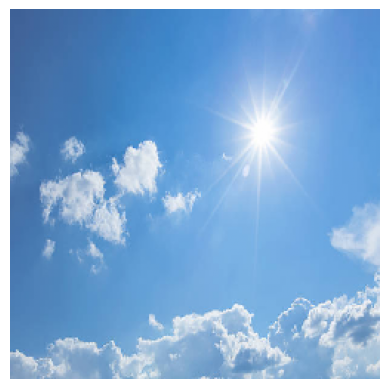

In [ ]:
path_image = '/content/img.jpg'
prediction(path_image)

1/1 [==============================] - 0s 18ms/step
Prediction Value:  0.60611826
Classified: Cloudy


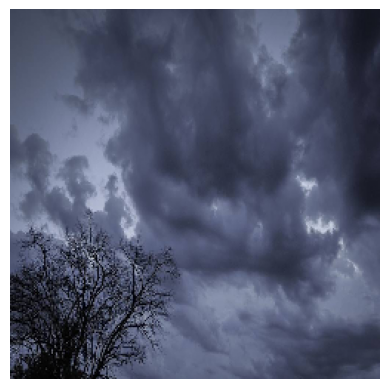

In [ ]:
path_image = '/content/img2.jpg'
prediction(path_image)

1/1 [==============================] - 0s 18ms/step
Prediction Value:  0.9997873
Classified: Rain


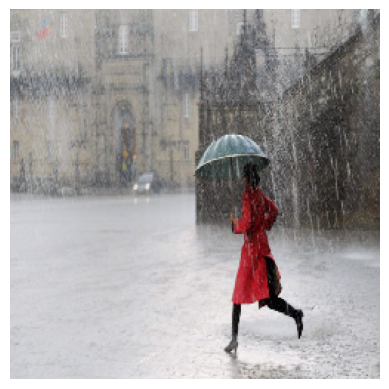

In [ ]:
path_image = '/content/img3.jpg'
prediction(path_image)

1/1 [==============================] - 0s 27ms/step
Prediction Value:  1.0
Classified: Sunrise


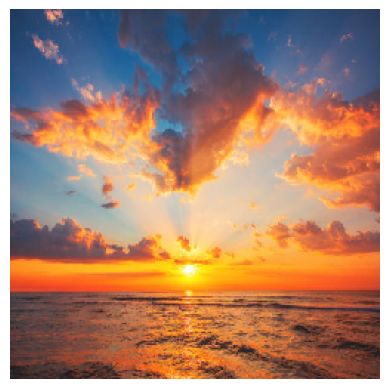

In [ ]:
path_image = '/content/img4.jpg'
prediction(path_image)

<b> Inferencia</b>: Los resultados del tercer modelo convolucional son:
<ul>
  <li> Función de pérdidad >> 21.85%</li>
  <li> Tasa de aciertos >> 90.90%</li>
  <li> El modelo presenta sobreajuste</li>
  <li> El modelo mejoró con respecto al primer modelo, ya que minimizó la pérdida y aumentó el accuracy. </li>
  <li> Clasificó "bien" con nuevos datos</li>
</ul>

### 3.3.3 Guardar el modelo 3

In [ ]:
model3.save('/content/drive/MyDrive/Weather_data/New_model.h5')
new_model = tf.keras.models.load_model('//content/drive/MyDrive/Weather_data/New_model.h5')


# 4. Carga y ajuste de modelo pre-entrenado.

## 4.1 Carga del modelo DenseNet201


<p><b>DenseNet201</b> es una arquitectura de red neuronal convolucional profunda que forma parte del módulo tf.keras.applications.densenet en TensorFlow. Es una variante del modelo DenseNet original propuesto por Huang et al. en 2017. </p>

<p>DenseNet se destaca por su arquitectura densamente conectada, donde cada capa está conectada directamente a todas las capas posteriores en un bloque de construcción específico. Esto permite un flujo de información más eficiente y una mejor reutilización de características en comparación con las arquitecturas convencionales.</p>

<p> Para más detalles técnicos, puede consultar en el siguiente <A href="https://www.tensorflow.org/api_docs/python/tf/keras/applications/densenet/DenseNet201">link.</A>

In [ ]:
## Ajuste de la entrada de las imágenes
input_shape = (250,250,3)

densenet = tf.keras.applications.DenseNet201(
    # Pesos pre-entrenados
    weights='imagenet',
    # No se incluye la capa fina de clasificación
    include_top=False,
    input_shape=input_shape)

for layer in densenet.layers:
    # Se congela los pesos de las capas pre-entredanas
    layer.trainable = False
# No se entrena el modelo
densenet.trainable = False
# Construcción del modelo
def build_model():
    model = Sequential()
    # Se agrega el modelo densenet
    model.add(densenet)
    # Capa de agrupación global
    model.add(GlobalAveragePooling2D())
    model.add(Dense(4096, activation='relu')) #sigmoid
    model.add(Dropout(0.3))
    # Capa final con 4 salidas
    model.add(Dense(4, activation='softmax'))

    # Compilación del modelo
    model.compile(
        loss='categorical_crossentropy',
        optimizer=tf.keras.optimizers.Adam(lr=1e-4), #1e-4
        metrics=['categorical_accuracy'])

    return model

model4 = build_model()

74836368/74836368 [==============================] - 1s 0us/step


In [ ]:
model4.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet201 (Functional)    (None, 7, 7, 1920)        18321984  
                                                                 
 global_average_pooling2d (G  (None, 1920)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense_6 (Dense)             (None, 4096)              7868416   
                                                                 
 dropout_7 (Dropout)         (None, 4096)              0         
                                                                 
 dense_7 (Dense)             (None, 4)                 16388     
                                                                 
Total params: 26,206,788
Trainable params: 7,884,804
Non-trainable params: 18,321,984
__________________________________

In [ ]:
# Configurar el número de épocas
epochs = 60

# Iniciar el temporizador
start_time = time.time()
## Entrenar el modelo

history = model4.fit(train_generator,
                    validation_data = validation_generator,
                    epochs = epochs,
                    steps_per_epoch = 901/32,
                    validation_steps = 224/32)

end_time = time.time()

Epoch 1/60
28/28 [==============================] - 45s 1s/step - loss: 0.5424 - categorical_accuracy: 0.8324 - val_loss: 0.2956 - val_categorical_accuracy: 0.8616
Epoch 2/60
28/28 [==============================] - 25s 893ms/step - loss: 0.1071 - categorical_accuracy: 0.9634 - val_loss: 0.1538 - val_categorical_accuracy: 0.9464
Epoch 3/60
28/28 [==============================] - 29s 1s/step - loss: 0.0753 - categorical_accuracy: 0.9678 - val_loss: 0.1845 - val_categorical_accuracy: 0.9196
Epoch 4/60
28/28 [==============================] - 25s 887ms/step - loss: 0.0629 - categorical_accuracy: 0.9756 - val_loss: 0.3068 - val_categorical_accuracy: 0.8929
Epoch 5/60
28/28 [==============================] - 24s 869ms/step - loss: 0.0490 - categorical_accuracy: 0.9822 - val_loss: 0.4205 - val_categorical_accuracy: 0.8839
Epoch 6/60
28/28 [==============================] - 24s 850ms/step - loss: 0.0580 - categorical_accuracy: 0.9734 - val_loss: 0.3236 - val_categorical_accuracy: 0.9062
Epoc

In [ ]:
## Calcular el tiempo de entrenamiento
training_time = end_time - start_time

# Convertir los tiempos a minutos
training_time_min = training_time / 60

# Imprimir los resultados
print(f"Tiempo de entrenamiento total del modelo DenseNet201: {training_time_min:.2f} minutos")

Tiempo de entrenamiento total del modelo DenseNet201: 29.22 minutos


### 4.1.1 Resultado del modelo DenseNet201

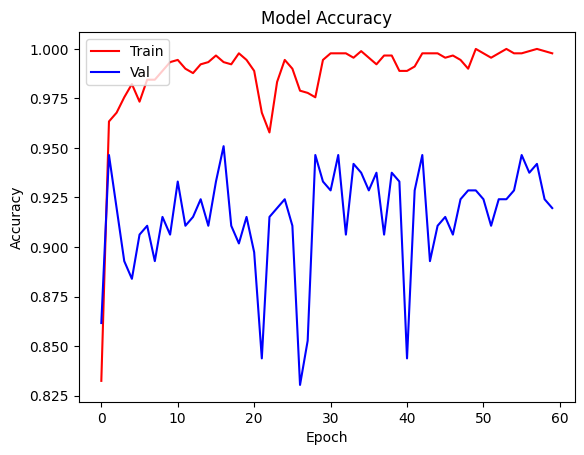

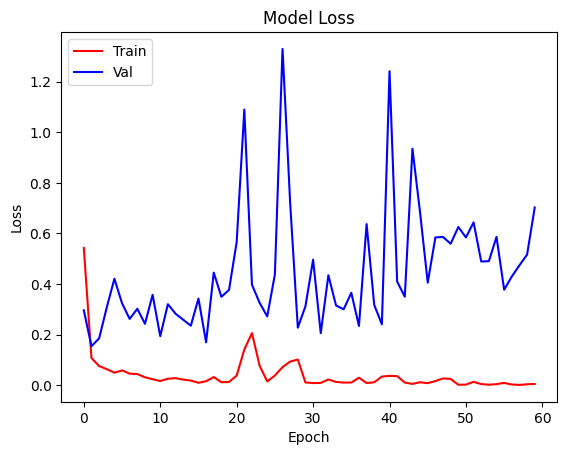

In [ ]:
plt.plot(history.history['categorical_accuracy'], 'r')
plt.plot(history.history['val_categorical_accuracy'], 'b')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()
# Ver la funcion de perdida del modelo
plt.plot(history.history['loss'], 'r')
plt.plot(history.history['val_loss'], 'b')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

In [ ]:
Loss, Accuracy = model4.evaluate(train_generator)

print(f"Loss: {Loss*100:.2f}%")
print(f"Accuracy: {Accuracy*100:.2f}%")

29/29 [==============================] - 19s 633ms/step - loss: 1.0714e-04 - categorical_accuracy: 1.0000
Loss: 0.01%
Accuracy: 100.00%


### 4.1.2 Predicción del modelo DenseNet201

In [ ]:
def prediction(path_image):

  img = image.load_img(path_image , target_size = (250 , 250))
  img = image.img_to_array(img, dtype=np.uint8)
  img = np.array(img)/255.0

  # plt.title('Image')
  plt.axis('off')
  plt.imshow(img.squeeze())

  predict = model4.predict(img[np.newaxis , ...])
  predicted_class = labels[np.argmax(predict[0] , axis = -1)]

  print('Prediction Value: ' , np.max(predict[0] , axis = -1))
  print("Classified:",predicted_class)

1/1 [==============================] - 0s 39ms/step
Prediction Value:  1.0
Classified: Shine


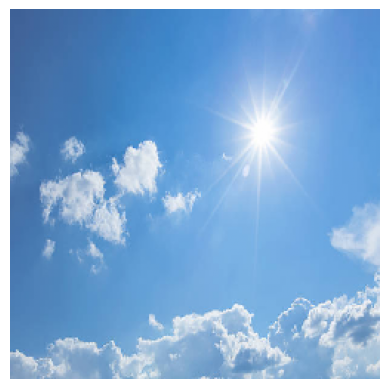

In [ ]:
path_image = '/content/img.jpg'
prediction(path_image)

1/1 [==============================] - 0s 36ms/step
Prediction Value:  1.0
Classified: Cloudy


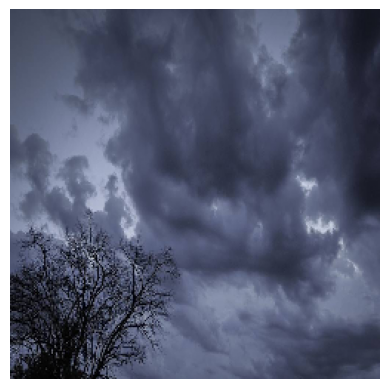

In [ ]:
path_image = '/content/img2.jpg'
prediction(path_image)

1/1 [==============================] - 0s 34ms/step
Prediction Value:  1.0
Classified: Rain


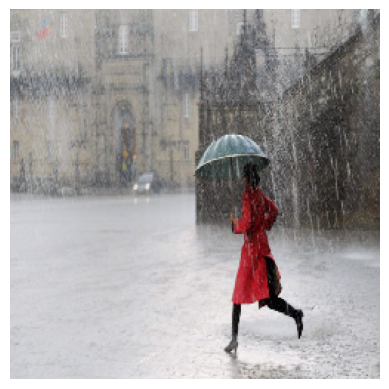

In [ ]:
path_image = '/content/img3.jpg'
prediction(path_image)

1/1 [==============================] - 0s 41ms/step
Prediction Value:  1.0
Classified: Sunrise


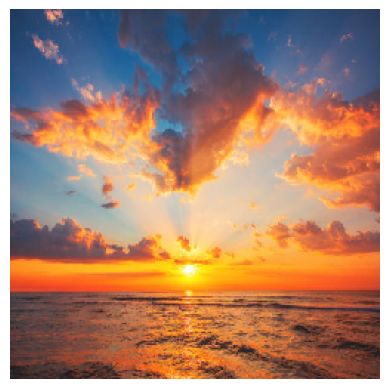

In [ ]:
path_image = '/content/img4.jpg'
prediction(path_image)

<b> Inferencia</b>: Los resultados del modelo DenseNet201 son:
<ul>
  <li>El modelo tiene sobre ajuste.</li>
  <li> Clasifica "bien" con nuevo datos.</li>
</ul>

# 5. Presentación de resultados

<p> A continuación se presentan los principales resultados.</p>
<br>

<center>
<table>
<tr>
  <th></th>
  <th><b> Modelo 1</b></th>
  <th><b> Modelo 2</b></th>
  <th><b> Modelo 3</b></th>
</tr>
<tr>
  <td><b> Función de pérdida</b> </td>
  <td> 35.58% </td>
  <td> 16.57% </td>
  <td> 21.85% </td>
</tr>
<tr>
  <td><b> Accuracy </b> </td>
  <td> 87.50% </td>
  <td> 96.12% </td>
  <td> 90.90% </td>
</tr>
</table>
</center>
<br>
<p> En general, el modelo 2 fue el que tuvo los mejores resultados, ya que tuvo el menor porcentaje de pérdida pero a la vez, la mejor tasa aciertos. Sin embargo, sigue presentando overfitting.

# 6. Conclusiones

<p> En modelos de Machine Learning y Deep Learning se busca dos cosas: minimizar lo máximo posible el error tratando de aumentar la tasa de aciertos; y en segundo lugar, se busca evitar el overfitting. El modelo 2 fue en comparación con los dos modelos el que mejor desempeño obtuvo, sin embargo, presenta overfitting, por lo que aún da margen para seguir mejorándolo. </p>

<p> El uso de un modelo pre-entrenado, como en el caso de DenseNet201, se hizo con el fin de obtener un mejor desempeño, no obstante, los resultados no fueron los esperados. Resta aún modificar y experimentar con los hiperamentros para tratar de ajustarlo de mejor manera. </p>

<b> Aprendizaje</b>

Queda mucho por aprender en el campo de la inteligencia artificial, pero como aprendizaje al trabajar con este proyecto se puede puntualizar lo siguiente. La experimentación es la clave para obtener mejores resultados, ya que no existe aún fórmulas generales que pueda resolver cada uno de los problemas presentados, por lo que cada problema precisa de una solución a veces única. </p>